In [1]:
%load_ext autoreload
%autoreload 2
from analysis_settings import *
from plot_settings import *
from scripts.corr_stats import _corr_results
from scripts.utils_plot import convert_pvalue_to_asterisks, _save_fig, _axes2d
from scripts.utils import _average_hemispheres
from matplotlib.patches import Patch
import scripts.config as cfg
import numpy as np
from scripts.utils_plot import _add_band
from matplotlib.ticker import PercentFormatter

In [2]:
sns.set_style('darkgrid')
ch_choice = 'ch_dist_sweet'
dataframes = get_dfs(ch_choice)
df_per = dataframes['df_per']

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

In [3]:
def center_freq_histogram_separate_single(df, xmax=45, conds=['off', 'on'],
                                          add_off_on=True):
    if df.fm_params.unique()[0] == 'broad':
        kind = 'periodic'
    else:
        kind = 'lorentzian'
    df = df[df.cond.isin(conds)]
    Y = 'fm_center_freqs'

    # Explode the lists into separate rows
    df = df.explode(Y).reset_index(drop=True)

    bins = np.arange(1, xmax+1, 2)  # 1 Hz resolution seems better than 2 Hz
    n_col = df.project.nunique()
    n_rows = len(conds)
    if add_off_on:
        n_rows += 1
    figsize_x = 7 if n_col > 6 else 1.5
    figsize_y = n_rows * 0.4
    fig, axes = plt.subplots(n_rows, n_col,
                            #  figsize=(7, 1.2),
                             figsize=(figsize_x, figsize_y),
                             sharex=True, sharey=True,
                            #  gridspec_kw={'height_ratios': [1, 1]}
                             )
    axes = _axes2d(axes, n_rows, n_col)

    for i, proj in enumerate(df.project.unique()):
        df_proj = df[(df.project == proj)]
        xticks = XTICKS_FREQ_low if i == 0 else XTICKS_FREQ_low[1:]
        xticks += [xmax]
        xticklabels = xticks.copy()
        xticklabels[1] = ''

        for j, cond in enumerate(conds):
            ax = axes[j, i]
            if n_col > 1:
                color = cfg.COLOR_DIC[proj] if cond == 'off' else cfg.COLOR_DIC[proj + "2"]
            else:
                color = cfg.COLOR_DIC[kind] if cond == 'off' else cfg.COLOR_DIC[kind + "2"]
            # title = df_proj.project_nme.unique()[0] if j == 0 else None
            title = None
            hist, bin_edges = np.histogram(df_proj[df_proj['cond'] == cond][Y], bins=bins)
            ax.hist(bin_edges[:-1], bin_edges, weights=hist, color=color,
                    density=False, label=cfg.COND_DICT[cond])
            # sns.histplot(data=df_proj[df_proj['cond'] == cond], ax=ax,
            #             color=color, **hist_kwargs)
            # ax.yaxis.set_major_formatter(PercentFormatter(1))
            ax.set_title(title)
            ax.set_xlim(1, xmax)
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticklabels)
            ax.set_xlabel(None)
            ax.set_ylabel(None)
            ax.legend(title=None, loc='upper right')
            # if proj == 'all':
            #     handle = [Patch(facecolor=color, label=cond)]
            #     ax.legend(title=None, loc='upper right', handles=handle)
            # else:
            #     ax.legend().remove()

        if add_off_on:
            # add off-on difference
            ax = axes[2, i]
            if n_col > 1:
                color = cfg.COLOR_DIC[proj] if cond == 'off' else cfg.COLOR_DIC[proj + "2"]
            else:
                color = cfg.COLOR_DIC[kind] if cond == 'off' else cfg.COLOR_DIC[kind + "2"]
            # title = df_proj.project_nme.unique()[0] if j == 0 else None
            title = None
            hist_off, bin_edges = np.histogram(df_proj[df_proj['cond'] == 'off'][Y], bins=bins)
            hist_on, bin_edges = np.histogram(df_proj[df_proj['cond'] == 'on'][Y], bins=bins)
            hist_off_on = hist_off - hist_on
            ax.hist(bin_edges[:-1], bin_edges, weights=hist_off_on, color='grey',
                    density=False, label=cfg.COND_DICT['offon_abs'])
            # ax.yaxis.set_major_formatter(PercentFormatter(1))
            # sns.histplot(data=df_proj[df_proj['cond'] == cond], ax=ax,
            #             color=color, **hist_kwargs)
            ax.set_title(title)
            ax.set_xlim(1, xmax)
            ax.set_xticks(xticks)
            ax.set_xlabel(None)
            ax.set_ylabel(None)
            ax.legend(title=None, loc='upper right')
        # if proj == 'all':
        #     handle = [Patch(facecolor=color, label='Off-On')]
        #     ax.legend(title=None, loc='upper right', handles=handle)
        # else:
        #     ax.legend().remove()
    # axes[0, 0].set_ylabel('Probability [%]')
    # axes[1, 0].set_ylabel('Probability [%]')
    # fig.supylabel('Probability\n[%]')
    # if n_col == 1:
    #     ax.set_ylabel('Peak probability\n[%]', ha='center')
    # else:
    fig.supylabel('Peak count', ha='center', x=0.1)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    cond_str = '_'.join(conds)
    if add_off_on:
        cond_str += '_offon'
    fname = f'fooof_histogram_{kind}_separate_single_{cond_str}'
    save_dir = join('Figure2', ch_choice, fname)
    _save_fig(fig, save_dir, SAVE_DIR, close=False,
              transparent=False, bbox_inches=None)



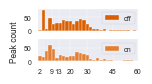

In [4]:
center_freq_histogram_separate_single(df_per[df_per.project == 'all'], conds=['off', 'on'], add_off_on=False, xmax=60)

In [5]:
def center_freq_histogram(df, xmax=45):
    if df.fm_params.unique()[0] == 'broad':
        kind = 'periodic'
    else:
        kind = 'lorentzian'
    df = df[df.cond.isin(['on', 'off'])]
    Y = 'fm_center_freqs'

    # Explode the lists into separate rows
    df = df.explode(Y).reset_index(drop=True)

    bins = np.arange(1, xmax+1, 1)  # 1 Hz resolution seems better than 2 Hz
    hist_kwargs = dict(x=Y, stat='percent', bins=bins, hue='cond',
                        hue_order=['off', 'on'])
    fig, axes = plt.subplots(1, 6, figsize=(7, 1), sharey=True)
    for i, proj in enumerate(cfg.PROJECT_ORDER_SLIM):
        df_proj = df[(df.project == proj)]
        palette = [cfg.COLOR_DIC[proj], cfg.COLOR_DIC[proj + "2"]]
        title = df_proj.project_nme.unique()[0]
        xticks = XTICKS_FREQ_low if i == 0 else XTICKS_FREQ_low[1:]
        ax = axes[i]
        sns.histplot(data=df_proj, ax=ax, palette=palette, **hist_kwargs)
        ax.set_title(df.project_nme.unique()[0])
        ax.set_xlim(1, 45)
        ax.set_xticks(xticks)
        ax.set_xlabel(None)
        ax.set_title(title)
        if proj == 'all':
            sns.move_legend(ax, "upper right", title=None)
        #     # handle = [Patch(facecolor=color, label=cond)]
        #     handles, labels = ax.get_legend_handles_labels()
        #     ax.legend(title=None, loc='upper right',
        #               handles=handles, labels=labels)
        else:
            ax.legend().remove()
        # axes[i].legend(title=None, loc='upper right')
        # axes[i].set_xlabel('Frequency (Hz)')
    # fig.supxlabel('Frequency (Hz)')
    axes[0].set_ylabel('Probability\n[%]')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05)
    fname = f'fooof_histogram_{kind}'
    save_dir = join(KIND_DIR[kind], ch_choice, fname)
    _save_fig(fig, save_dir, SAVE_DIR, close=False,
            transparent=False, bbox_inches=None)


def center_freq_histogram_separate(df, xmax=45):
    if df.fm_params.unique()[0] == 'broad':
        kind = 'periodic'
    else:
        kind = 'lorentzian'
    df = df[df.cond.isin(['on', 'off'])]
    Y = 'fm_center_freqs'

    # Explode the lists into separate rows
    df = df.explode(Y).reset_index(drop=True)

    bins = np.arange(1, xmax+1, 1)  # 1 Hz resolution seems better than 2 Hz
    hist_kwargs = dict(x=Y, stat='percent', bins=bins)

    fig, axes = plt.subplots(2, 6,
                            #  figsize=(7, 1.2),
                             figsize=(7, 1),
                             sharex=True, sharey=True,
                             gridspec_kw={'height_ratios': [1, 1]})

    for i, proj in enumerate(cfg.PROJECT_ORDER_SLIM):
        df_proj = df[(df.project == proj)]
        xticks = XTICKS_FREQ_low if i == 0 else XTICKS_FREQ_low[1:]

        for j, cond in enumerate(['off', 'on']):
            ax = axes[j, i]
            color = cfg.COLOR_DIC[proj] if cond == 'off' else cfg.COLOR_DIC[proj + "2"]
            # title = df_proj.project_nme.unique()[0] if j == 0 else None
            title = None
            sns.histplot(data=df_proj[df_proj['cond'] == cond], ax=ax,
                        color=color, **hist_kwargs)
            ax.set_title(title)
            ax.set_xlim(1, xmax)
            ax.set_xticks(xticks)
            ax.set_xlabel(None)
            ax.set_ylabel(None)
            if proj == 'all':
                handle = [Patch(facecolor=color, label=cond)]
                ax.legend(title=None, loc='upper right', handles=handle)
            else:
                ax.legend().remove()
    # axes[0, 0].set_ylabel('Probability [%]')
    # axes[1, 0].set_ylabel('Probability [%]')
    # fig.supylabel('Probability\n[%]')
    fig.supylabel('Peak probability\n[%]', ha='center')
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    fname = f'fooof_histogram_{kind}_separate'
    save_dir = join(KIND_DIR[kind], ch_choice, fname)
    _save_fig(fig, save_dir, SAVE_DIR, close=False,
              transparent=False, bbox_inches=None)

/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_93338/156944945.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_93338/156944945.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_93338/156944945.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_93338/156944945.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label st

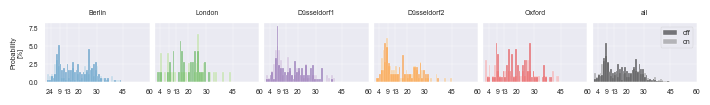

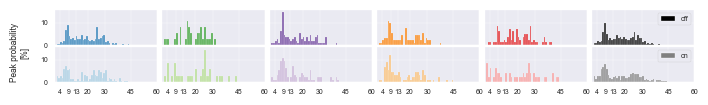

In [6]:
# Run your function with the DataFrame `df`
center_freq_histogram(df_per)
center_freq_histogram_separate(df_per)


In [7]:
# # center_freq_histogram(df_lor)
# center_freq_histogram_separate_single(df_lor[df_lor.project == 'all'], conds=['off', 'on'], add_off_on=True)
# center_freq_histogram_separate_single(df_lor[df_lor.project == 'all'], conds=['off', 'on'], add_off_on=False)

In [8]:
# # Run your function with the DataFrame `df`
# center_freq_histogram(df_abs)
# center_freq_histogram_separate(df_abs)


In [9]:
# center_freq_histogram(df_lor)
# center_freq_histogram_separate(df_lor)

In [10]:
# kind = 'periodic'
# df_proj = df_abs[df_abs.cond.isin(['on']) & (df_abs.project == 'all')]
# Y = 'fm_center_freqs'
# xmin = 2
# xmax = 60
# freq_res = 3
# # for freq_res in range(1, 4, 1):
# # Explode the lists into separate rows
# df_proj = df_proj.explode(Y).reset_index(drop=True)

# bins = np.arange(xmin, xmax+1, freq_res)  # 1 Hz resolution seems better than 2 Hz
# hist_kwargs = dict(x=Y, stat='percent', bins=bins, label='On')

# fig, ax = plt.subplots(1, 1, figsize=(2, 1))

# color = cfg.COLOR_DIC['all']
# sns.histplot(data=df_proj, ax=ax, color=color, **hist_kwargs)
# # ax.set_title(title)
# ax.set_xlim(xmin, xmax)
# ax.set_xticks(XTICKS_FREQ_high, labels=XTICKS_FREQ_high_labels)
# ax.set_xlabel(None)
# ax.set_ylabel('Probability\n[%]')
# _add_band('gamma_broad', ax, labels=False)
# ax.legend(title=None, loc='upper right')
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.05, wspace=0.05)
# fname = f'fooof_histogram_{kind}_separate_{xmax}_{freq_res}'
# save_dir = join('Figure5', ch_choice, fname)
# _save_fig(fig, save_dir, SAVE_DIR, close=False,
#             transparent=False, bbox_inches=None)

